# Independent Component Analysis (ICA)

**Content Creator**: Maria de Fátima Dias

It is an approach that finds the best linear transformation that maximizes the independence of the features, in a statistical point of view.
There are two ways to solve this problem:
  

1.   Maximization of the nongaussianity of the estimation:
      *   Kurtosis
      *   Negentropy
2.   Minimization of the mutual information:
      *   Maximum entropy
      *   Kullback‐Leibler divergence


## Cocktail party problem

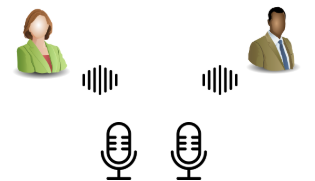

### Comparing two statiscally independent sources with an uniform distribution

For the sake of simplification we will analyse a problem in which two sources of signal, $s$, are being collected from two different microphones. The microphones captured signal, $X$, is given by the equation:

> $X = As$

where $A$ represents each source weight for each microphone and has the following structure:
 
\begin{array}{|l|l|l|}
\hline
a11&a12 \\ \hline
a21&a22 \\ \hline
\end{array}
 
Below you can play with the weights that each microphone is capturing from each one of the sources, the weight $w_{ij}$ represents the $j$-th source weight on the $i$ microphone.

In [1]:
#@title
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interactive
import ipywidgets as widgets

def generate_random_distribution_sources(a11: float=2, a12: float=3, a21: float=4, a22: float=2):

  min_value = -5
  max_value = 5
  n_sources = 2
  number_samples = 2000

  sources = np.zeros((n_sources, number_samples))

  for source_i in range(n_sources):
    sources[source_i, :] = np.random.uniform(low=min_value, high=max_value, size=number_samples)

  transformation_matrix = np.asarray([[a11, a12],
                                      [a21, a22]])


  transformed_data = np.matmul(transformation_matrix, sources)
  
  f, ax = plt.subplots(1, 2, figsize=(25, 5))
  ax[0].plot(sources[0], sources[1], 'o')
  ax[1].plot(transformed_data[0], transformed_data[1], 'o')
  ax[0].set_title("Original distibution")
  ax[0].set_xlabel("Source 1")
  ax[0].set_ylabel("Source 2")
  ax[1].set_title("Captured distibution")
  ax[1].set_xlabel("Mixture 1")
  ax[1].set_ylabel("Mixture 2")
  return transformed_data, transformation_matrix

w = interactive(generate_random_distribution_sources, a11=(0.0,20.0,0.5), a12=(0.0,20.0,0.5), a21=(0.0,20.0,0.5), a22=(0.0,20.0,0.5))
display(w)

interactive(children=(FloatSlider(value=2.0, description='a11', max=20.0, step=0.5), FloatSlider(value=3.0, de…

#### FastICA

In the exercise below you can find an application of the FastICA algorithm to the capture distribution that you generated above.

Text(0, 0.5, 'Independent Sources 2')

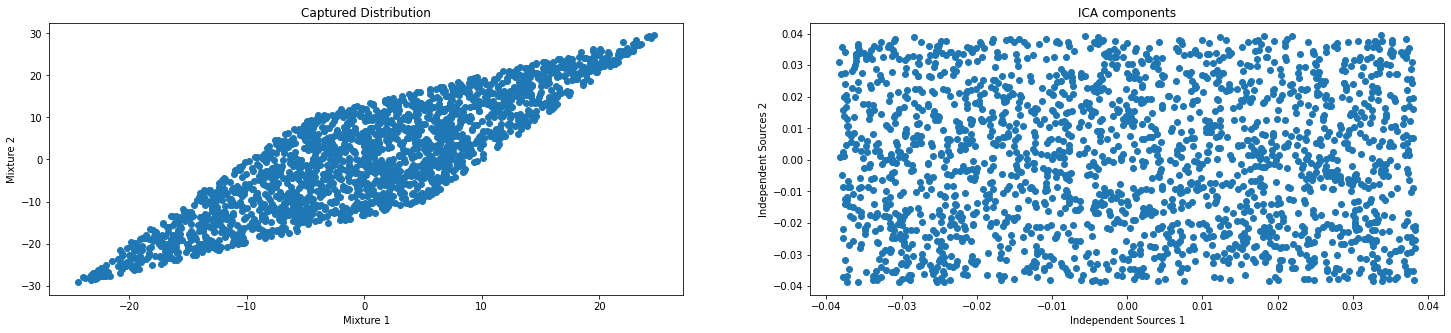

In [2]:
#@title
from sklearn.decomposition import FastICA

X, A = w.result
ica_model = FastICA(n_components=2, random_state=0)
X_transformed = ica_model.fit_transform(X.T)
f, ax = plt.subplots(1, 2, figsize=(25, 5))
_ = ax[0].plot(X[0], X[1], 'o')
_ = ax[1].plot(X_transformed[:, 0], X_transformed[:, 1], 'o')
_ = ax[0].set_title("Captured Distribution")
_ = ax[1].set_title("ICA components")
ax[0].set_xlabel("Mixture 1")
ax[0].set_ylabel("Mixture 2")
ax[1].set_xlabel("Independent Sources 1")
ax[1].set_ylabel("Independent Sources 2")


##### Comparing the matrix A and W 

In [3]:
#@title
print(f'A matrix:\n{A}, \n\nW matrix:\n{ica_model.mixing_}')

A matrix:
[[2. 3.]
 [4. 2.]], 

W matrix:
[[-258.86001313 -387.49367215]
 [-521.34987164 -261.14362131]]


# EEG - Noise cleaning example


In [4]:
## Download data
import urllib.request 
import pandas as pd

url_data = 'https://github.com/mfmachado/adar/raw/main/resources/data_example.csv'
data_filename = 'data_example'
print(f'Downloading data file')
urllib.request.urlretrieve(url_data, data_filename)

df_all = pd.read_csv(url_data)

## Visualizing Data

In [5]:
df_all.head(4)

,Fp2-F4,F4-C4,C4-P4,FP1-F3,F3-C3,C3-P3,P3-O1,C4-A1,ROC-LOC,EMG1-EMG2,ECG1-ECG2,HR,PLETH,Position,times,sleepstage
0,-9.004884e-07,-1.678877e-07,-2.213065e-06,-0.000004,1.724664e-06,0.000002,0.000002,-6.105128e-08,-0.000007,5.647131e-07,-0.000018,73.01442,-0.012704,3.0,7812.500000,S2
1,-2.823565e-06,-3.815629e-07,-2.762515e-06,-0.000004,-4.120879e-07,0.000002,-0.000001,-7.875615e-06,-0.000011,1.526252e-08,-0.000017,73.01442,0.001747,3.0,7812.515625,S2
2,-4.136142e-06,1.144689e-06,-2.289377e-07,-0.000009,-7.478632e-07,0.000003,0.000001,6.715641e-07,-0.000003,5.341880e-07,-0.000015,73.01442,0.017953,3.0,7812.531250,S2
3,-1.327839e-06,2.152015e-06,-3.678266e-06,-0.000009,-2.365690e-06,-0.000001,-0.000004,-5.769346e-06,0.000006,-6.868132e-07,-0.000016,73.01442,0.034143,3.0,7812.546875,S2


## Select the electrodes desired

In [6]:
df = df_all[['times', 'sleepstage', 'Fp2-F4', 'F4-C4', 'C4-P4', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'C4-A1']]
df.head(4)

# Exclude the times, sleepstage and columns
columns_electrodes = [el for el in df.columns if el not in ["times", "sleepstage"]]

## Plotting data




#### Prepare the data

 
To improve the data visualization we should:
 
 
*  Transform the sleep stages from string into a numeric;
*  Normalize or standardize the data;
 
The latter is required because if the sleep stages vary between 0 and 4, and the maximum of the signal is 0.05 for instance, then it would be hard to see the signals when plotted with the sleep stages.

The Map of the sleep stage to an ID's is the following: 


*   W: 0
*   S1: 1
*   S2: 2
*   S3: 3
*   S4: 3
*   R: 4





In [7]:
from sklearn.preprocessing import MinMaxScaler 

# Conversion sleep stages to Id's
sleep_stages_ids = {"W": 0, "S1": 1, "S2": 2, "S3":3, "S4":3, "R": 4}
sleep_stages_parsed = df["sleepstage"].apply(lambda x: sleep_stages_ids[x])
# Scale the signal
matrix_data_scaled = MinMaxScaler().fit_transform(df[columns_electrodes])*sleep_stages_parsed.max()

# The scaler the returns a matrix, convert the matrix back to a DataFrane
df_standard = pd.DataFrame(matrix_data_scaled, columns=columns_electrodes)

# Added column with times
df_standard["times"] = df.times

# Convert the sleep stage to ID's
df_standard["sleepstage"] = sleep_stages_parsed

### A signal per plot

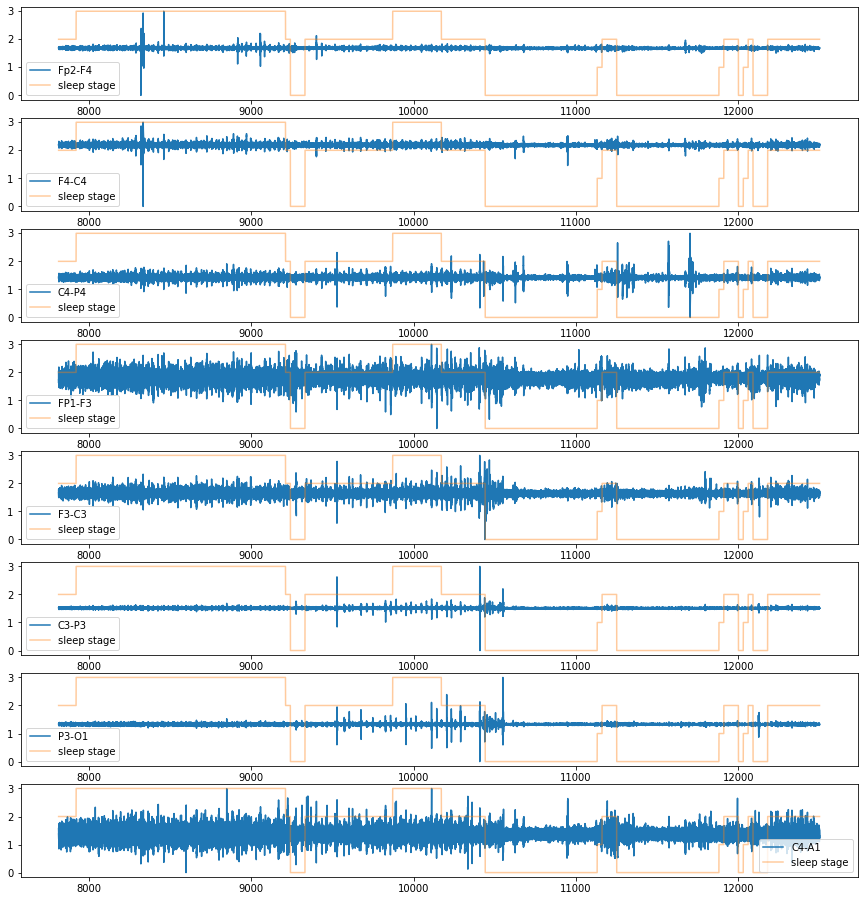

In [8]:
f, ax = plt.subplots(len(columns_electrodes), 1, figsize=(15, 2*len(columns_electrodes)))
for i, column_name in enumerate(columns_electrodes):
  ax[i].plot(df["times"], df_standard[column_name], label=column_name)
  ax[i].plot(df["times"], df_standard["sleepstage"], alpha=0.4, label="sleep stage")
  ax[i].legend()

### Multiple signals in one plot only




In [9]:
def plot_multiple(df_data, columns_plot, ax2):
  """
  This function receives a dataframe, the column names that one desires to plot 
  and the Axes plot
  """

  plt_columns = columns_plot.copy()
  # Plot also sleep stage
  plt_columns.append("sleepstage")

  n_rows = len(plt_columns)
  dmin = df_data[plt_columns].min().min()
  dmax = df_data[plt_columns].max().max()
  dr = (dmax - dmin) * 0.7  # Crowd them a bit.
  y0 = dmin
  y1 = (n_rows - 1) * dr + dmax
  ax2.set_ylim(y0, y1)
  ticklocs=[]
  segs = []
  ax2.set_xlim([df_data.times.min(), df_data.times.max()])
  ax2.set_ylim(y0, y1)

  for i, column_name in enumerate(plt_columns):
      segs.append(df_data[["times", column_name]].to_numpy())
      ticklocs.append(i * dr)
  

  offsets = np.zeros((n_rows, 2), dtype=float)
  offsets[:, 1] = ticklocs

  lines = LineCollection(segs, offsets=offsets, transOffset=None)
  ax2.add_collection(lines)

  # Set the yticks to use axes coordinates on the y axis
  _ = ax2.set_yticks(ticklocs)
  # Set the yticks to use axes coordinates on the y axis
  ax2.set_yticks(ticklocs)
  ax2.set_yticklabels(plt_columns)

  ax2.set_xlabel('Time (s)')


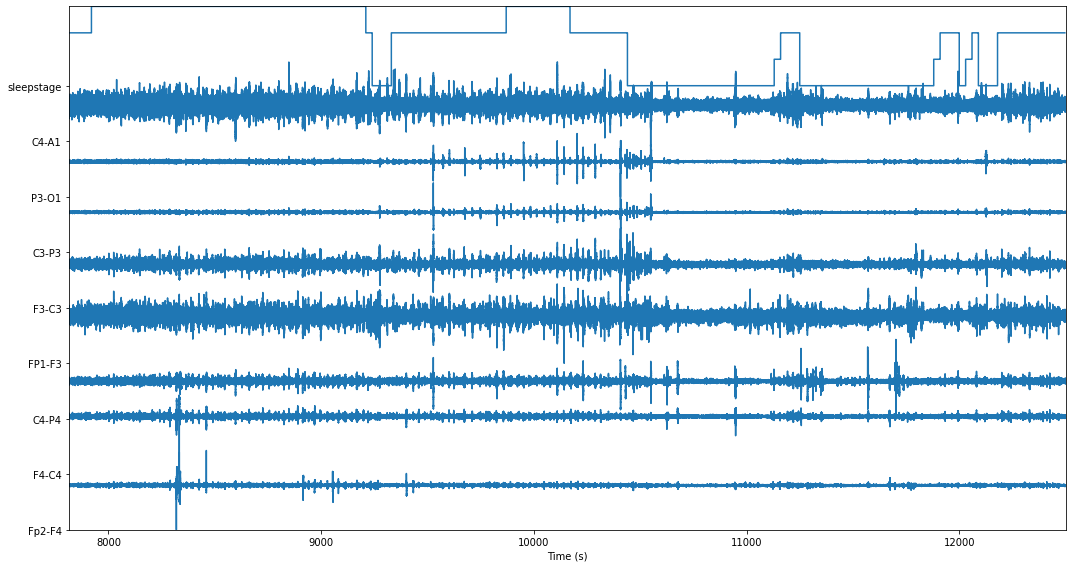

In [10]:
from matplotlib.collections import LineCollection

f, ax_multiple = plt.subplots(1, 1, figsize=(15, 8)) 
plot_multiple(df_standard, columns_electrodes, ax_multiple)

plt.tight_layout()
plt.show()

## Apply ICA

In [11]:
ica_model = FastICA(n_components=len(columns_electrodes), random_state=0)

# Apply ICA only to the electrodes (exclude sleep stages and times)
independent_sources = ica_model.fit_transform(df_standard[columns_electrodes])

# Apply the Min-Max Scaler
scaled_independent_sources = MinMaxScaler().fit_transform(independent_sources)*df_standard["sleepstage"].max()

# The fit_transform returns a matrix, convert it to dataframe
components_columns_name = [f'component#{el}' for el in range(len(columns_electrodes))]
df_sources = pd.DataFrame(data=scaled_independent_sources, columns=components_columns_name)
df_sources["times"] = df_standard["times"]
df_sources["sleepstage"] = df_standard["sleepstage"]
df_sources.head(4)

,component#0,component#1,component#2,component#3,component#4,component#5,component#6,component#7,times,sleepstage
0,1.609485,0.795588,1.091469,1.557948,1.587292,1.620942,1.676725,1.675245,7812.500000,2
1,1.600971,0.790029,1.091106,1.607619,1.651747,1.617731,1.666745,1.671136,7812.515625,2
2,1.597179,0.774791,1.093289,1.647876,1.560758,1.617782,1.674527,1.676083,7812.531250,2
3,1.608295,0.759750,1.077218,1.682627,1.631493,1.620032,1.661276,1.685462,7812.546875,2


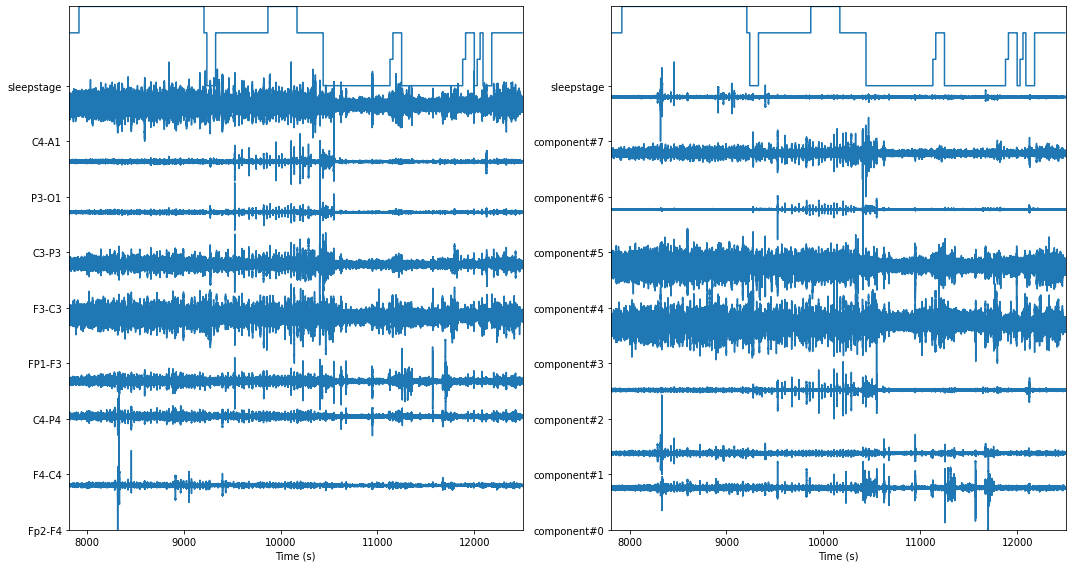

In [12]:
f, ax_ica = plt.subplots(1, 2, figsize=(15, 8)) 
plot_multiple(df_standard, columns_electrodes, ax_ica[0])
plot_multiple(df_sources, components_columns_name, ax_ica[1])
plt.tight_layout()
plt.show()

See a smaller portion of the signal

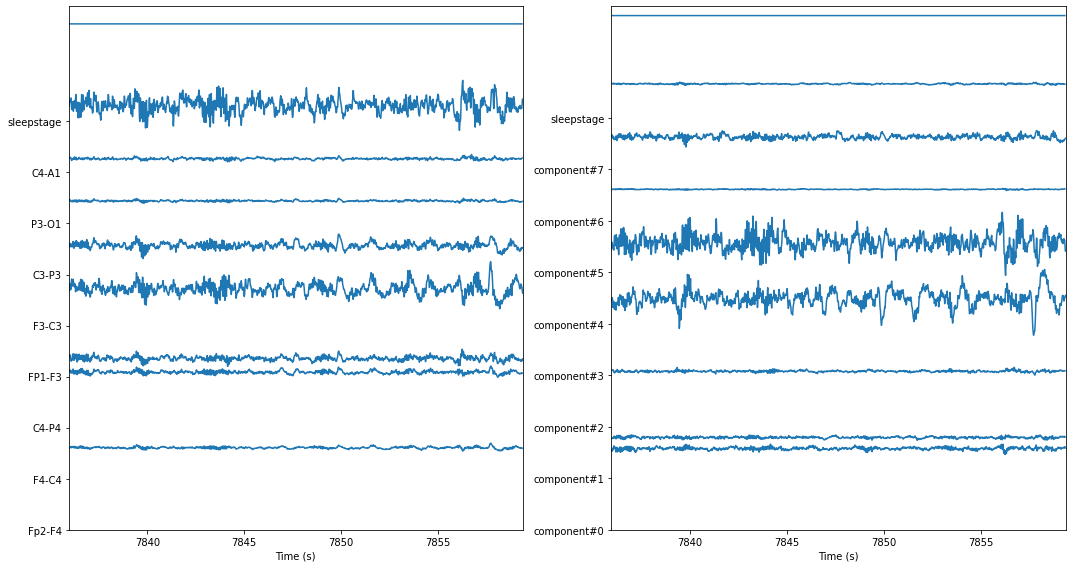

In [13]:
f, ax_ica = plt.subplots(1, 2, figsize=(15, 8)) 
plot_multiple(df_standard.iloc[1500:3000], columns_electrodes, ax_ica[0])
plot_multiple(df_sources.iloc[1500:3000], components_columns_name, ax_ica[1])
plt.tight_layout()
plt.show()

## Denoising with ICA

In the example below you can see the effect on the reconstructed signal whe ont is considering a single component as noise.

In [14]:
def remove_a_component(model_ica, df_indp_sources, column_name_component_rejected):

  df_sources_clean = df_indp_sources.copy()
  df_sources_clean[column_name_component_rejected] = 0

  # Times and sleep stages cannot be used in the reconstruction 
  cols = [el for el in df_sources_clean.columns if el not in ["times", "sleepstage"]]
  X_restored = model_ica.inverse_transform(df_sources_clean[cols])
  X_restored_scaled = MinMaxScaler().fit_transform(X_restored)*df_indp_sources["sleepstage"].max()
  return  X_restored_scaled

def plot_with_wihout_component(model_ica, df_indp_sources, column_name_component_rejected, data_original):
  _ = plt.clf()
  print(f'Removing component {column_name_component_rejected}, this might take a few seconds.')
  columns_orig = [el for el in data_original.columns if el not in ["times", "sleepstage"]]
  sources_clean = remove_a_component(model_ica, df_indp_sources, column_name_component_rejected)
  df_sources_clean = pd.DataFrame(data=sources_clean, columns=columns_orig)

  df_sources_clean["times"] = data_original["times"]
  df_sources_clean["sleepstage"] = data_original["sleepstage"]

  f, ax_clean = plt.subplots(1, 3, figsize=(25, 15)) 
  plot_multiple(df_standard, columns_electrodes, ax_clean[0])
  plot_multiple(df_indp_sources, components_columns_name, ax_clean[1])
  plot_multiple(df_sources_clean, columns_electrodes, ax_clean[2])
  plt.tight_layout()
  plt.show()


### Exercice 1: Interact with the widget to learn about the effect of considering a ICA component as noise.

In [15]:
from IPython.html.widgets import interact, fixed
# plot_with_wihout_component(ica_model, df_sources, df_sources.columns[3], df_standard)
interact(plot_with_wihout_component, column_name_component_rejected=components_columns_name, model_ica=fixed(ica_model), df_indp_sources=fixed(df_sources), data_original=fixed(df_standard));

/usr/local/lib/python3.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


interactive(children=(Dropdown(description='column_name_component_rejected', options=('component#0', 'componen…